In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
#from ptitprince import RainCloud

from pandas_profiling import ProfileReport
%matplotlib inline
pd.set_option('display.max_rows', 50)

print(os.getcwd())

/content


In [4]:
from lightgbm import LGBMModel
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm

In [5]:
INPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Solafune/夜間光データから土地価格を予測/data/inputs/'
OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Solafune/夜間光データから土地価格を予測/data/outputs/'
NB_NAME = 'nb013'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train = pd.read_csv(os.path.join(INPUT_DIR, 'TrainDataSet.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR, 'EvaluationData.csv'))
submission = pd.read_csv(os.path.join(INPUT_DIR, 'UploadFileTemplate.csv'))
target = train['AverageLandPrice']

# 前処理

In [6]:
# 面積を追加
def calc_area(input_df):
    output_df = input_df.copy()
    output_df['Area'] = input_df['SumLight'] / input_df['MeanLight']
    # 小数点以下でずれあるが、測定地域の面積は変わらないはずなので中央値に置き換え
    _mapping = output_df.groupby('PlaceID')['Area'].median()
    output_df['Area'] = output_df['PlaceID'].map(_mapping)
    # NaNがあるので0置き換え
    output_df['Area'] = output_df['Area'].fillna(0)
    return output_df

In [7]:
train = calc_area(train)
test = calc_area(test)

# 特徴量

In [8]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df) -> pd.DataFrame:
        raise NotImplementedError()

In [9]:
# count 63
class Count63Block(BaseBlock):
    def transform(self, input_df):
        output_df = pd.DataFrame()
        output_df['PlaceID'] = input_df['PlaceID'].copy()

        _mapping = input_df[input_df['MeanLight'] == 63].groupby('PlaceID').size()
        output_df['count63'] = output_df['PlaceID'].map(_mapping).fillna(0)
        return output_df['count63']

In [10]:
# aggregationのagg_methodsで使用する関数群
# 分位点
def third_quartile(x):
    return x.quantile(0.75)
def first_quartile(x):
    return x.quantile(0.25)
def quartile_range(x):
    return x.quantile(0.75) - x.quantile(0.25)

def max_min(x):
    return x.max() - x.min()

In [11]:
# agg計算関数(xfeat.aggregation参照)
def aggregation(input_df, group_key, group_values, agg_methods):
    new_df = []
    for agg_method in agg_methods:
        for col in group_values:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            new_col = f"agg_{agg_method_name}_{col}_grpby_{group_key}"
            df_agg = (input_df[[col] + [group_key]].groupby(group_key)[[col]].agg(agg_method))
            df_agg.columns = [new_col]
            new_df.append(df_agg)
            
    _df = pd.concat(new_df, axis=1).reset_index()
    output_df = pd.merge(input_df[[group_key]], _df, on=group_key, how="left")
    return output_df.drop(group_key, axis=1)


# PlaceIDをキーにした集約特徴量
class AggPlaceIDBlock(BaseBlock):
    def __init__(self, group_values, agg_methods):
        self.group_values = group_values
        self.agg_methods = agg_methods

    def transform(self, input_df):
        output_df = aggregation(input_df,
                               'PlaceID',
                                group_values=self.group_values,
                                agg_methods=self.agg_methods)

        return output_df


# Year をキーにした集約特徴量
class AggYearBlock(BaseBlock):
    def __init__(self, group_values, agg_methods):
        self.group_values = group_values
        self.agg_methods = agg_methods

    def transform(self, input_df):
        output_df = aggregation(input_df,
                               'Year',
                                group_values=self.group_values,
                                agg_methods=self.agg_methods)
        return output_df

In [12]:
# diff計算関数
def diff_aggregation(input_df, group_key, group_values, num_diffs):
    dfs = []
    for nd in num_diffs:
        _df = input_df.groupby(group_key)[group_values].diff(nd)
        _df.columns = [f'diff={nd}_{col}_grpby_{group_key}' for col in group_values]
        dfs.append(_df)
    output_df = pd.concat(dfs, axis=1)
    return output_df


# PlaceID をキーにしたグループ内差分(マイナスからプラスまで差の取り方いっぱいあるな)
class LagPlaceIDBlock(BaseBlock):
    def __init__(self, group_key, group_values, num_diffs):
        self.group_key = group_key
        self.group_values = group_values
        self.num_diffs = num_diffs
    
    def transform(self, input_df):
        output_df = diff_aggregation(input_df,
                                     group_key=self.group_key,
                                     group_values=self.group_values,
                                     num_diffs=self.num_diffs)
        return output_df

In [13]:
# shift計算関数
def shift_aggregation(input_df, group_key, group_values, num_shifts):
    dfs = []
    for ns in num_shifts:
        _df = input_df.groupby(group_key)[group_values].shift(ns)
        _df.columns = [f'shift={ns}_{col}_grpby_{group_key}' for col in group_values]
        dfs.append(_df)
    output_df = pd.concat(dfs, axis=1)
    return output_df

# PlaceID をキーにしたグループ内シフト
# あまり意味ないかもしれない？
class ShiftPlaceIDBlock(BaseBlock):
    def __init__(self, group_key, group_values, num_shifts):
        self.group_key = group_key
        self.group_values = group_values
        self.num_shifts = num_shifts

    def transform(self, input_df):
        output_df = shift_aggregation(input_df,
                                      self.group_key,
                                      self.group_values,
                                      self.num_shifts)
        return output_df

In [14]:
# PCAを単体でするときのコンポーネント数
COMPONENT = 16

# 主性成分分析する
def make_vec_features(input_df, index, columns, values):
    all_pca_df = _all_df = pd.DataFrame()
    
    # valuesそれぞれでpivotしてpca
    for val in values:
        _df = pd.pivot_table(input_df, index=index, columns=columns, values=val).fillna(0).add_prefix(val + '=')
        _all_df = pd.concat([_all_df, _df], axis=1)
        sc_df = StandardScaler().fit_transform(_df.fillna(0))
        pca = PCA(n_components=COMPONENT, random_state=1993)
        pca_df = pd.DataFrame(pca.fit_transform(sc_df), index=_df.index).rename(columns=lambda x: f"PlaceID_{val}_PCA_{x:03}")
        all_pca_df = pd.concat([all_pca_df, pca_df], axis=1)
    # values全部でpca
    sc_all_df = StandardScaler().fit_transform(_all_df.fillna(0))
    pca = PCA(n_components=COMPONENT * (len(values)+1), random_state=1993)
    pca_df = pd.DataFrame(pca.fit_transform(sc_all_df), index=_all_df.index).rename(columns=lambda x:f"PlaceID_All_PCA_{x:03}")

    all_pca_df= pd.concat([all_pca_df, pca_df], axis=1)
    output_df = pd.merge(input_df[[index]], all_pca_df, left_on=index, right_index=True, how='left')
    return output_df.drop('PlaceID', axis=1)

# pivot tabel を用いた特徴量
class PlaceID2VecBlock(BaseBlock):
    def __init__(self, index, columns, values):
        self.index = index
        self.columns = columns
        self.values = values

    def transform(self, input_df):
        return make_vec_features(input_df, self.index, self.columns, self.values)

In [15]:
# PlaceIDをキーにしたグループ内相関係数
class PlaceIDcorrBlock(BaseBlock):
    def __init__(self, group_key, group_values):
        self.group_key = group_key
        self.group_values = group_values

    def transform(self, input_df):
        dfs = []
        for gv in self.group_values:
            _df = input_df.groupby(self.group_key)[gv].corr().unstack().iloc[:, 1].rename(f"Corr={gv[0]}-{gv[1]}")
            dfs.append(pd.DataFrame(_df))
        dfs = pd.concat(dfs, axis=1)
        output_df = pd.merge(input_df[[self.group_key]], dfs, left_on=self.group_key, right_index=True, how='left').drop(self.group_key, axis=1)
        return output_df      

In [16]:
# 各特徴量同士の四則演算?

In [26]:
#SumLightとAreaを順位付け
class RankBlock(BaseBlock):
    def transform(self, input_df):
        _df = []
        sumli_rank_df = input_df.groupby('PlaceID')['SumLight'].mean().rank(ascending=False)
        area_rank_df = input_df.groupby('PlaceID')['Area'].mean().rank()
        _df = pd.concat([sumli_rank_df, area_rank_df], axis=1)
        _df.columns = ['SumLight_rank', 'Area_rank']
        _df['AreaSumLig_rank'] = ( sumli_rank_df + area_rank_df ) / 2.0

        output_df = pd.merge(input_df[['PlaceID']], _df, left_on='PlaceID', right_index=True, how='left')
        return output_df.drop('PlaceID', axis=1)

In [17]:
# binning
class BinningBlock(BaseBlock):
    def __init__(self, num_bin, group_key, group_values):
        self.num_bin = num_bin
        self.group_key = group_key
        self.group_values = group_values

    def transform(self, input_df):
        new_df = []
        for gv in self.group_values:
            _mean_df = input_df.groupby(self.group_key)[[gv]].mean()
            bin = pd.cut(_mean_df[gv], self.num_bin, labels=False).rename(f'Bin_{gv}')
            new_df.append(bin)

        _df = pd.concat(new_df, axis=1).reset_index()
        output_df = pd.merge(input_df[[self.group_key]], _df, on=self.group_key, how='left')
        return output_df.drop(self.group_key, axis=1)

In [18]:
# sum_mean_df = train.groupby('PlaceID')[['SumLight']].mean()
# area_mean_df = train.groupby('PlaceID')[['Area']].mean()
# df_mean = pd.merge(sum_mean_df, area_mean_df, on='PlaceID', how='left')
# df_mean.columns = ['SumLight_mean', 'Area_mean']

# bin = pd.cut(df_mean['SumLight_mean'], 10, labels=False).rename('aaa')

# #df_mean = pd.merge(train[['PlaceID']], df, on='PlaceID', how='left')

# #df.columns = ['SumLight_mean', 'Area_mean']
# bin
# # a = pd.DataFrame(bin)
# # a.columns=['bin_SumLight_mean']
# # a

In [19]:
# bi = BinningBlock(100, 'PlaceID', ['SumLight', 'Area'])
# result = bi.transform(train)
# result.head(50)

In [31]:
class GroupKFold:
    """
    GroupKFold with random shuffle with a sklearn-like structure
    """

    def __init__(self, n_splits=4, shuffle=True, random_state=1993):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, group=None):
        return self.n_splits

    def split(self, X=None, y=None, group=None):
        kf = model_selection.KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)
        unique_ids = group.unique()
        for tr_group_idx, va_group_idx in kf.split(unique_ids):
            # split group
            tr_group, va_group = unique_ids[tr_group_idx], unique_ids[va_group_idx]
            train_idx = np.where(group.isin(tr_group))[0]
            val_idx = np.where(group.isin(va_group))[0]
            yield train_idx, val_idx


# PlaceID をキーにした Group K fold
def make_gkf(X, y, n_splits=5, random_state=1993):
    gkf = GroupKFold(n_splits=n_splits, random_state=random_state)
    return list(gkf.split(X, y, group))


# 評価関数(log(目的変数)を使っているためrmseを用いる)
def root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** .5

In [39]:
train_x.filter(like='Bin')

,Bin_Area,Bin_SumLight
0,0,7
1,0,7
2,0,7
3,0,7
4,0,7
...,...,...
21878,3,19
21879,3,19
21880,3,19
21881,3,19


In [78]:
d = {'SumLight': train['SumLight']}

pd.DataFrame(d)

,SumLight
0,403.0
1,439.0
2,433.0
3,432.0
4,440.0
...,...
21878,1032.0
21879,1573.0
21880,1184.0
21881,1226.0


In [70]:
#data_temp = pd.DataFrame({'Bin_Area': tr_x[c], 'target': tr_y})
#なんでこれできないの？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？

In [119]:
cv=make_gkf
train_df = train_x[['Bin_Area']]

for i, (tr_idx, va_idx) in enumerate(cv(train_df, train_y, n_splits=5)):
    tr_x, va_x = train_df.values[tr_idx], train_df.values[va_idx]
    tr_y, va_y = train_y.values[tr_idx], train_y.values[va_idx]

    c = 'Bin_Area'
    tmp1 = pd.DataFrame(data=tr_x, columns=['Bin_Area'])
    tmp2 = pd.DataFrame(data=tr_y, columns=['target'])
    data_temp = pd.concat([tmp1, tmp2], axis=1)

    target_mean = data_temp.groupby('Bin_Area')['target'].mean()
    va_df = pd.DataFrame(data=va_x, columns=['Bin_Area'])
    #va_x.loc[:, c] = va_x[c].map(target_mean)
    va_df = va_df['Bin_Area'].map(target_mean)

    tmp = np.repeat(np.nan, tr_x.shape[0])
    for idx_1, idx_2 in cv(tr_x, tr_y, n_splits=5):
        print(data_temp)
        target_mean = data_temp.iloc[idx_1].groupby('Bin_Area')['target'].mean()
        tmp[idx_2] = tr_x[c].iloc[idx_2].map(target_mean)

    tr_x.loc[:, c] = tmp

tr_x

KeyError: ignored

In [59]:
class TargetEncoBin(BaseBlock):
    def __init__(self, cv, cat_cols, folds):
        self.cv = cv
        selfcat_cols = cat_cols
        self.folds = folds

    def transform(self, input_df, target_df):
        for i, (tr_idx, va_idx) in enumerate(self.cv(input_df, target_df, n_splits= self.folds)):
            tr_x, va_x = input_df.values[tr_idx], input_df.values[va_idx]
            tr_y, va_y = target_df.values[tr_idx], target_df.values[va_idx]

            for c in self.cat_cols:
                print
                data_temp = pd.DataFrame({c: tr_x[c], 'target': tr_y})
                target_mean = data_temp.groupby(c)['target'].mean()
                va_x.loc[:, c] = va_x[c].map(tartget_mean)

                tmp = np.repeat(np.nan, tr_x.shape[0])
                for idx_1, idx_2 in self.cv(tr_x, tr_y, n_splits= self.folds):
                    target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
                    tmp[idx_2] = tr_x[c].iloc[idx_2].map(target_mean)

                tr_x.loc[:, c] = tmp
        return tr_x

In [61]:
cla = TargetEncoBin(cv=make_gkf, cat_cols=['Bin_SumLight'], folds=5)
aaa = cla.transform(train_x, train_y)

Bin_SumLight
<class 'str'>


IndexError: ignored

In [54]:
# そのまま使う特徴量
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function

    def transform(self, input_df):
        return self.function(input_df)

def origin_features(input_df):
    use_columns = [
        'Year',
        'MeanLight',
        'SumLight',
        'Area'
    ]
    return input_df[use_columns]

In [21]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None,format_str='{:.3f}[s]',prefix=None,suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time()-start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [22]:
from tqdm import tqdm

def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)

def to_feature(input_df, blocks, is_train=False):
    output_df = pd.DataFrame()

    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)

        with timer(prefix='create' + str(block) + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        output_df = pd.concat([output_df, _df], axis=1)

    return output_df

In [23]:
print(len(train['Area'].value_counts()))
print(len(train['SumLight'].value_counts()))

924
6981


In [27]:
agg_methods = ["min", "max", "median", "mean", "std", max_min, third_quartile, first_quartile, quartile_range]

num_diffs = range(1, 22)
num_shifts = range(1, 22)
group_vlaues = [
    ["Year", "MeanLight"],
    ["Year", "SumLight"],
    ["Year", "Area"],
]         

process_blocks = [
    WrapperBlock(origin_features),
    Count63Block(),
    AggPlaceIDBlock(["MeanLight", "SumLight", "Area"], agg_methods),
    AggYearBlock(["MeanLight", "SumLight", "Area"], agg_methods),
    LagPlaceIDBlock('PlaceID', ["MeanLight", "SumLight"], num_diffs),
    ShiftPlaceIDBlock('PlaceID', ["MeanLight", "SumLight"], num_shifts),
    PlaceID2VecBlock("PlaceID", "Year", ["Area", "MeanLight", "SumLight"]),
    PlaceIDcorrBlock("PlaceID", group_vlaues),
    RankBlock(),
    BinningBlock(90, "PlaceID", ["Area"]),
    BinningBlock(700, "PlaceID", ["SumLight"]),
]

train_x = to_feature(train, process_blocks, is_train=True)
test_x = to_feature(test, process_blocks, is_train=False)
# RMSLE → RMSE
train_y = np.log1p(target)

  0%|          | 0/11 [00:00<?, ?it/s]

create<__main__.WrapperBlock object at 0x7f0b89ab6e10> 0.003[s]
create<__main__.Count63Block object at 0x7f0b89ab6150> 0.005[s]


 27%|██▋       | 3/11 [00:06<00:18,  2.32s/it]

create<__main__.AggPlaceIDBlock object at 0x7f0b89ab6a90> 6.954[s]


 36%|███▋      | 4/11 [00:07<00:11,  1.71s/it]

create<__main__.AggYearBlock object at 0x7f0b89ab6350> 0.265[s]


 45%|████▌     | 5/11 [00:13<00:18,  3.06s/it]

create<__main__.LagPlaceIDBlock object at 0x7f0b89ab6750> 6.210[s]
create<__main__.ShiftPlaceIDBlock object at 0x7f0b89ab6210> 0.074[s]


 64%|██████▎   | 7/11 [00:13<00:08,  2.21s/it]

create<__main__.PlaceID2VecBlock object at 0x7f0b89ab6a10> 0.298[s]


  0%|          | 0/11 [00:00<?, ?it/s]

create<__main__.PlaceIDcorrBlock object at 0x7f0b89ab6890> 1.196[s]
create<__main__.RankBlock object at 0x7f0b89ab69d0> 0.013[s]
create<__main__.BinningBlock object at 0x7f0b89ab6490> 0.009[s]
create<__main__.BinningBlock object at 0x7f0b89ab67d0> 0.010[s]
create<__main__.WrapperBlock object at 0x7f0b89ab6e10> 0.001[s]
create<__main__.Count63Block object at 0x7f0b89ab6150> 0.005[s]


 27%|██▋       | 3/11 [00:04<00:11,  1.43s/it]

create<__main__.AggPlaceIDBlock object at 0x7f0b89ab6a90> 4.277[s]


 36%|███▋      | 4/11 [00:04<00:07,  1.08s/it]

create<__main__.AggYearBlock object at 0x7f0b89ab6350> 0.251[s]


 45%|████▌     | 5/11 [00:08<00:10,  1.81s/it]

create<__main__.LagPlaceIDBlock object at 0x7f0b89ab6750> 3.525[s]
create<__main__.ShiftPlaceIDBlock object at 0x7f0b89ab6210> 0.059[s]


 64%|██████▎   | 7/11 [00:08<00:05,  1.31s/it]

create<__main__.PlaceID2VecBlock object at 0x7f0b89ab6a10> 0.182[s]


100%|██████████| 11/11 [00:09<00:00,  1.19it/s]

create<__main__.PlaceIDcorrBlock object at 0x7f0b89ab6890> 0.805[s]
create<__main__.RankBlock object at 0x7f0b89ab69d0> 0.011[s]
create<__main__.BinningBlock object at 0x7f0b89ab6490> 0.009[s]
create<__main__.BinningBlock object at 0x7f0b89ab67d0> 0.009[s]


In [30]:
model = LGBMModel  # 使うモデル
group = train["PlaceID"]  # 今回は group kfold を用いる！

# model の parameter
model_params = {  
    "n_estimators": 10000,
    "objective": 'rmse',
    "learning_rate": 0.01,
    "num_leaves": 31,
    "random_state": 2021,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .5,
    "reg_lambda": 5
    }

# fit 時の parameter
fit_params = {
    "early_stopping_rounds": 100,
    "verbose": False
}

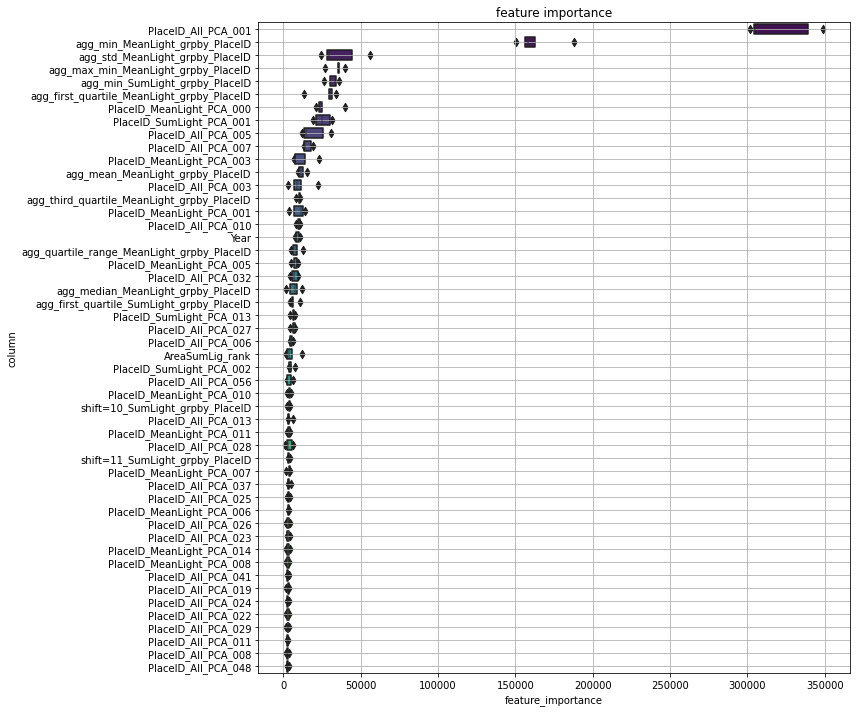

In [32]:
def tree_importance(X, y, model, model_params, fit_params, cv, folds):
    est = model(**model_params)
    feature_importance_df = pd.DataFrame()
    for i, (tr_idx, va_idx) in enumerate(cv(X, y, n_splits=folds)):
        tr_x, va_x = X.values[tr_idx], X.values[va_idx]
        tr_y, va_y = y.values[tr_idx], y.values[va_idx]
        est.fit(tr_x, tr_y,
                eval_set=[[va_x, va_y]],
                **fit_params) 
        _df = pd.DataFrame()
        _df['feature_importance'] = est.feature_importances_
        _df['column'] = X.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)
    order = feature_importance_df.groupby('column') \
                .sum()[['feature_importance']] \
                .sort_values('feature_importance', ascending=False).index[:50]
    fig, ax = plt.subplots(figsize=(12, max(4, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax,
                  palette='viridis')
    fig.tight_layout()
    ax.grid()
    ax.set_title('feature importance')
    fig.tight_layout()
    plt.show()
    return fig, feature_importance_df
    
fig, _ = tree_importance(train_x, train_y, model, model_params, fit_params, cv=make_gkf, folds=5)

In [33]:
def predict_cv(X, y, model, model_params, fit_params, cv, folds, seeds, metrics, name=""):
    oof_seeds = []; scores_seeds = []; models = {}
    for seed in seeds:
        oof = []; va_idxes = []; scores = []
        train_x, train_y = X.values, y.values
        fold_idx = cv(train_x, train_y, n_splits=folds, random_state=seed) 
        if "random_state" in model_params:
            model_params["random_state"] = seed
            
        # train and predict by cv folds
        for cv_num, (tr_idx, va_idx) in enumerate(fold_idx):
            tr_x, va_x = train_x[tr_idx], train_x[va_idx]
            tr_y, va_y = train_y[tr_idx], train_y[va_idx]
            va_idxes.append(va_idx)
            est = model(**model_params)

            # fitting - train
            est.fit(tr_x, tr_y,
                    eval_set=[[va_x, va_y]],
                    **fit_params) 
            model_name = f"{name}_SEED{seed}_FOLD{cv_num}_model"
            models[model_name] = est  # save model

            # predict - validation
            pred = est.predict(va_x)
            oof.append(pred)

            # validation score
            score = metrics(va_y, pred)
            scores.append(score)
            print(f"SEED:{seed}, FOLD:{cv_num} >>>> val_score:{score:.4f}")

        # sort as default
        va_idxes = np.concatenate(va_idxes)
        oof = np.concatenate(oof)
        order = np.argsort(va_idxes)
        oof = oof[order]
        oof_seeds.append(oof)
        scores_seeds.append(np.mean(scores))

    oof = np.mean(oof_seeds, axis=0)
    print(f"model:{name} score:{metrics(train_y, oof):.4f}\n")
    return oof, models
    
# oof予測値と学習済みモデルをGet!
oof, models = predict_cv(train_x, train_y, model,  # 説明変数, 目的変数, モデル
                         model_params,  # モデルパラメータ 
                         fit_params,  # fit時のパラメータ
                         cv=make_gkf,  # cv strategy 
                         folds=5,   # num folds
                         seeds=[0, 1, 2], # 3 seed average
                         metrics=root_mean_squared_error,  # 評価関数
                         name="lgbm"
                        )			

SEED:0, FOLD:0 >>>> val_score:0.5337
SEED:0, FOLD:1 >>>> val_score:0.5287
SEED:0, FOLD:2 >>>> val_score:0.5896
SEED:0, FOLD:3 >>>> val_score:0.5360
SEED:0, FOLD:4 >>>> val_score:0.5538
SEED:1, FOLD:0 >>>> val_score:0.5307
SEED:1, FOLD:1 >>>> val_score:0.5534
SEED:1, FOLD:2 >>>> val_score:0.5159
SEED:1, FOLD:3 >>>> val_score:0.5531
SEED:1, FOLD:4 >>>> val_score:0.5523
SEED:2, FOLD:0 >>>> val_score:0.5604
SEED:2, FOLD:1 >>>> val_score:0.5537
SEED:2, FOLD:2 >>>> val_score:0.5354
SEED:2, FOLD:3 >>>> val_score:0.5273
SEED:2, FOLD:4 >>>> val_score:0.5420
model:lgbm score:0.5374



In [34]:
# テストデータを学習済みモデルで予測
def predict_test(test_x, models):
    preds = []
    for name, est in models.items():
        print(f"{name} >>>> ")
        _pred = est.predict(test_x)
        preds.append(_pred)
    preds = np.mean(preds, axis=0)
    return preds
    
# 提出用の予測値をGet!
preds = predict_test(test_x, models)

lgbm_SEED0_FOLD0_model >>>> 
lgbm_SEED0_FOLD1_model >>>> 
lgbm_SEED0_FOLD2_model >>>> 
lgbm_SEED0_FOLD3_model >>>> 
lgbm_SEED0_FOLD4_model >>>> 
lgbm_SEED1_FOLD0_model >>>> 
lgbm_SEED1_FOLD1_model >>>> 
lgbm_SEED1_FOLD2_model >>>> 
lgbm_SEED1_FOLD3_model >>>> 
lgbm_SEED1_FOLD4_model >>>> 
lgbm_SEED2_FOLD0_model >>>> 
lgbm_SEED2_FOLD1_model >>>> 
lgbm_SEED2_FOLD2_model >>>> 
lgbm_SEED2_FOLD3_model >>>> 
lgbm_SEED2_FOLD4_model >>>> 


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

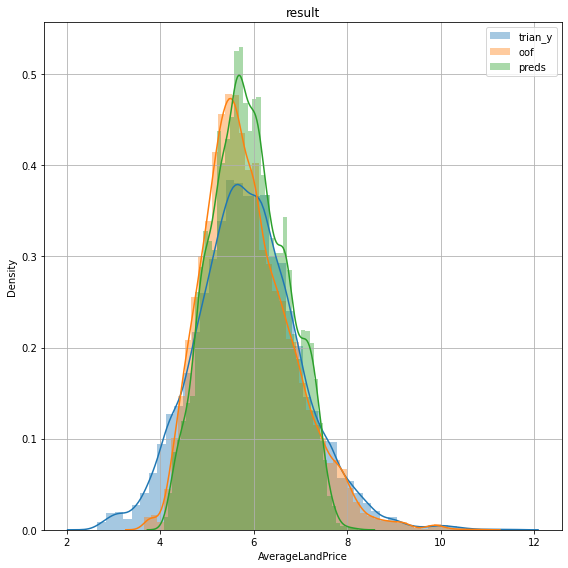

In [35]:
def result_plot(train_y, oof, preds):
    name = "result"
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(train_y, label='trian_y')
    sns.distplot(oof, label='oof')
    sns.distplot(preds, label='preds')
    ax.legend()
    ax.grid()
    ax.set_title(name)
    fig.tight_layout()
    plt.show()

result_plot(train_y, oof, preds)

# Model

In [ ]:
!pip install catboost

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoost
from catboost import Pool
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

In [ ]:
from abc import abstractmethod
class Base_Model(object):
    @abstractmethod
    def fit(self, x_train, y_train, x_valid, y_valid):
        raise NotImplementedError

    @abstractmethod
    def predict(self, model, features):
        raise NotImplementedError

    def cv(self, y_train, train_features, test_features, fold_ids):
        test_preds = np.zeros(len(test_features))
        oof_preds = np.zeros(len(train_features))

        for i_fold, (trn_idx, val_idx) in enumerate(fold_ids):
            x_trn = train_features.iloc[trn_idx]
            y_trn = y_train[trn_idx]
            x_val = train_features.iloc[val_idx]
            y_val = y_train[val_idx]

            with timer(prefix=f'fit fold={i_fold}'):
                model = self.fit(x_trn, y_trn, x_val, y_val)

            oof_preds[val_idx] = self.predict(model, x_val)
            oof_score = np.sqrt(mean_squared_error(y_val, oof_preds[val_idx]))
            print('fold{}:RMSLE{}'.format(i_fold, oof_score))
            test_preds += self.predict(model, test_features) / len(fold_ids)

        oof_score = np.sqrt(mean_squared_error(y_train, oof_preds))
        print(f'oof score: {oof_score}')

        evals_results = {"evals_result": {
            "oof_score": oof_score,
            "n_data": len(train_features),
            "n_features": len(train_features.columns),
        }}

        return oof_preds, test_preds, evals_results

In [ ]:
cat_col = []
class Lgbm(Base_Model):
    def __init__(self, model_params):
        self.model_params = model_params
        self.models = []
        self.feature_cols = None

    def fit(self, x_train, y_train, x_valid, y_valid):
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_valid = lgb.Dataset(x_valid, y_valid)

        model = lgb.train(self.model_params,
            train_set=lgb_train,
            valid_sets=[lgb_valid],
            valid_names=['valid'],
            categorical_feature=cat_col,
            early_stopping_rounds=100,
            num_boost_round=10000,
            verbose_eval=False)
        self.models.append(model)
        return model

    def predict(self, model, features):
        self.feature_cols = features.columns
        return model.predict(features)

    def visualize_importance(self):
        feature_importance_df = pd.DataFrame()

        for i,model in enumerate(self.models):
            _df = pd.DataFrame()
            _df['feature_importance'] = model.feature_importance(importance_type='gain')
            _df['column'] = self.feature_cols
            _df['fold'] = i+1
            feature_importance_df = pd.concat([feature_importance_df, _df],axis=0, ignore_index=True)

        order = feature_importance_df.groupby('column').sum()[['feature_importance']].sort_values('feature_importance', ascending=False).index[:50]

        fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
        sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
        ax.tick_params(axis='x', rotation=90)
        ax.grid()
        fig.tight_layout()
        return fig,ax

class Cat(Base_Model):
    def __init__(self, model_params):
        self.model_params = model_params
        
    def fit(self, x_train, y_train, x_valid, y_valid):
        train_pool = Pool(x_train,
                          label=y_train,
                          cat_features=cat_col)
        valid_pool = Pool(x_valid,
                          label=y_valid,
                          cat_features=cat_col)

        model = CatBoost(self.model_params)
        model.fit(train_pool,
                  early_stopping_rounds=100,
                 plot=False,
                 use_best_model=True,
                 eval_set=[valid_pool],
                  verbose=False)

        return model

    def predict(self, model, features):
      pred = model.predict(features)
      return pred

class Xgb(Base_Model):
    def __init__(self,model_params):
        self.model_params = model_params

    def fit(self, x_train, y_train, x_valid, y_valid):
        xgb_train = xgb.DMatrix(x_train, label=y_train)
        xgb_valid = xgb.DMatrix(x_valid, label=y_valid)

        evals = [(xgb_train, 'train'),(xgb_valid, 'eval')]

        model = xgb.train(self.model_params,
                         xgb_train,
                         num_boost_round=2000,
                         early_stopping_rounds=100,
                         evals=evals,
                         verbose_eval=False)

        return model

    def predict(self, model, features):
        return model.predict(xgb.DMatrix(features))

class Rid(Base_Model):
    def __init__(self):
      self.model = None
    def fit(self, x_train, y_train, x_valid, y_valid):
        model =Ridge(
            alpha=1, #L2係数
            max_iter=1000,
            random_state=10,
                              )
        model.fit(x_train, y_train)
        return model

    def predict(self,model, features):
      return model.predict(features)

# Learning

In [ ]:
cat_col =[]
cat_params = {
    'loss_function': 'RMSE',
    'num_boost_round': 10000,
    'depth':6
}

cat_model = Cat(cat_params)
oof_preds_cat, test_preds_cat, evals_results_cat = cat_model.cv(
    y, train_feat_df, test_feat_df, cv
)

fit fold=034.766[s]
fold0:RMSLE0.5476798765496286
fit fold=178.336[s]
fold1:RMSLE0.5204703390254615
fit fold=2159.243[s]
fold2:RMSLE0.5886129931295841
fit fold=359.423[s]
fold3:RMSLE0.5146118127906519
fit fold=4140.795[s]
fold4:RMSLE0.5680488971554531
oof score: 0.5486008846823541


In [ ]:
lgbm_params = {
    "boosting_type": "gbdt",
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6,
    'n_estimators': 10000,
    'num_leaves':31,
    'learning_rate':0.01,
    'colsample_bytree': .5,
    "verbose":-1
}

lgbm_model = Lgbm(lgbm_params)
oof_preds_lgb, test_preds_lgb, evals_results_lgb = lgbm_model.cv(
    y, train_feat_df, test_feat_df, cv
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


fit fold=024.360[s]
fold0:RMSLE0.5418638864239352


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


fit fold=148.130[s]
fold1:RMSLE0.5270232654107729


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


fit fold=281.504[s]
fold2:RMSLE0.5848953157923288


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


fit fold=327.785[s]
fold3:RMSLE0.5029601203385279


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


fit fold=437.319[s]
fold4:RMSLE0.5627377681600442
oof score: 0.5446310554121688


In [ ]:
xgb_params = {
    'max_depth': 6,
    'lambda':10, 
    'objective': 'reg:squarederror',
    'eval_metric':'rmse',
    'tree_method':'gpu_hist',
    'learning_rate':0.01
}

xgb_model = Xgb(xgb_params)
oof_preds_xgb, test_preds_xgb, evals_results_xgb = xgb_model.cv(
    y, train_feat_df, test_feat_df, cv
)

fit fold=041.408[s]
fold0:RMSLE0.5577607864452231
fit fold=138.882[s]
fold1:RMSLE0.5279673088281733
fit fold=252.329[s]
fold2:RMSLE0.5951548035837616
fit fold=389.357[s]
fold3:RMSLE0.5012021855820947
fit fold=446.875[s]
fold4:RMSLE0.5774260639408083
oof score: 0.5529340186554769


# Stacking

In [ ]:
stack_train_df = pd.DataFrame([oof_preds_cat, oof_preds_lgb, oof_preds_xgb]).T
stack_test_df = pd.DataFrame([test_preds_cat, test_preds_lgb, test_preds_lgb]).T

In [ ]:
stack_model = Rid()
oof_preds_stack, test_preds_stack, evals_results_stack = stack_model.cv(
    y, stack_train_df, stack_test_df, cv
)

fit fold=00.004[s]
fold0:RMSLE0.5433186908794785
fit fold=10.003[s]
fold1:RMSLE0.5185437647463588
fit fold=20.003[s]
fold2:RMSLE0.5815415827310071
fit fold=30.003[s]
fold3:RMSLE0.5041236697452267
fit fold=40.003[s]
fold4:RMSLE0.5625757482543288
oof score: 0.542753435656031


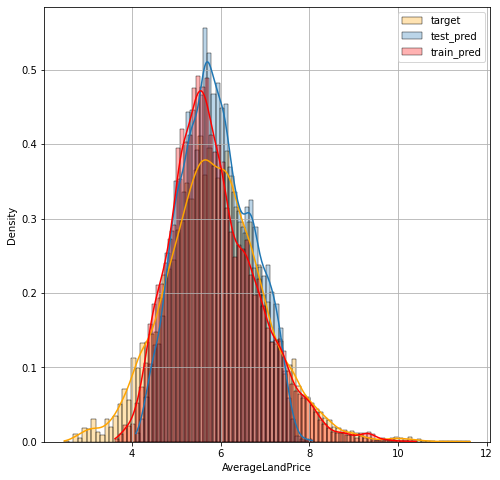

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(y, label='target', kde=True, stat='density', common_norm=False, alpha=0.3, color='orange')
sns.histplot(test_preds_stack, label='test_pred', kde=True, stat='density', common_norm=False, alpha=0.3)
sns.histplot(oof_preds_stack, label='train_pred', kde=True, stat='density', common_norm=False, alpha=0.3, color='red')
ax.legend()
ax.grid()

(<Figure size 1440x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f59744732d0>)

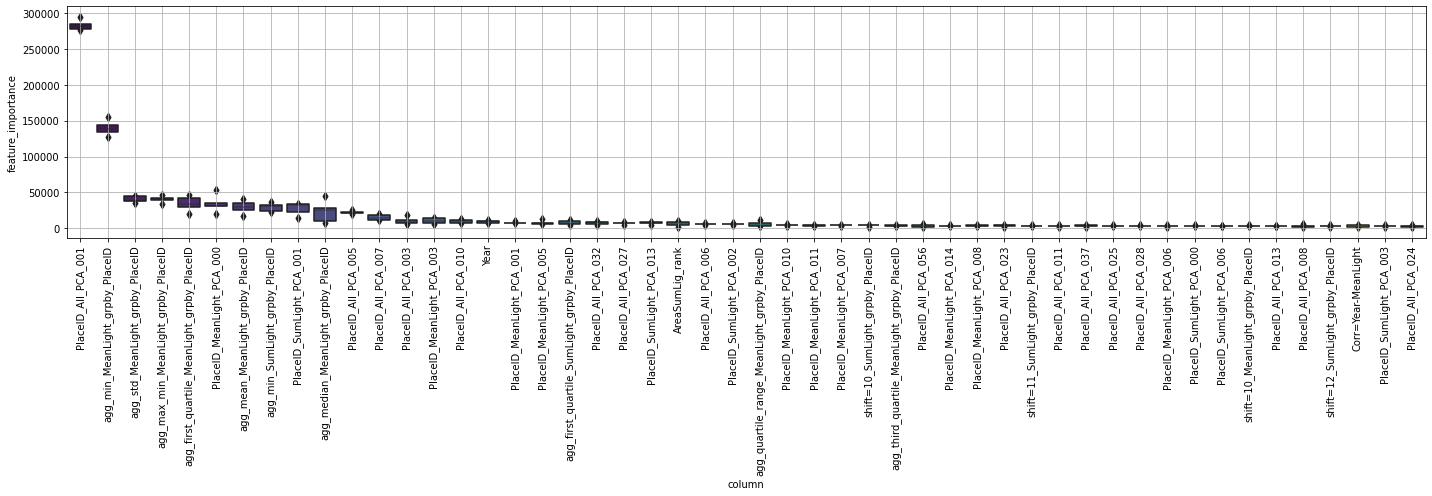

In [ ]:
lgbm_model.visualize_importance()

In [ ]:
y_sub = np.expm1(test_preds_stack)
submission['LandPrice'] = y_sub

submission.to_csv(os.path.join(OUTPUT_DIR, 'sub_' + NB_NAME + '.csv'), index=False)